In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

In [4]:
from scipy.signal.windows import dpss

In [5]:
from tqdm import tqdm

In [6]:
# CCAT-prime
zmin = 3.5
zmax = 8.1
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[26]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = Pei * (eIeI + eLOeLO - eIeLO - eLOeI)

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)



0.004498432668969444
13


[]

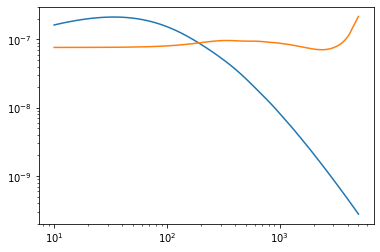

In [7]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [8]:
dchi = np.mean(np.diff(chis_resample))

In [9]:
from tqdm import tqdm

In [10]:
D = np.diag(chis_resample[window])

In [11]:
d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', d.T, x) / (ClKK + f_N0(ells))

LinAlgError: Matrix is not positive definite

In [12]:
res2 = np.zeros(len(ells), dtype = np.float64)
for ell_idx, ell in tqdm(enumerate(ells)):
    d = D @ IHi_kappa_windowed[ell_idx]
    cov_tmp = eHIeHI * (ClKK[ell_idx] + f_N0(ell))
    L = np.linalg.cholesky(D @ cov_tmp @ D)
    y = np.linalg.solve(L, d)
    x = np.linalg.solve(L.T, y)
    res2[ell_idx] = np.dot(d, x)

0it [00:00, ?it/s]


LinAlgError: Matrix is not positive definite

In [13]:
res3 = np.zeros(len(ells), dtype = np.float64)
for ell_idx, ell in tqdm(enumerate(ells)):
    d = D @ IHi_kappa_windowed[ell_idx]
    cov_tmp = (eHIeHI * (ClKK[ell_idx] + f_N0(ell))
               + IHi_kappa_windowed[ell_idx].reshape(1, -1) 
               * IHi_kappa_windowed[ell_idx].reshape(-1, 1))
    L = np.linalg.cholesky(D @ cov_tmp @ D)
    y = np.linalg.solve(L, d)
    x = np.linalg.solve(L.T, y)
    res3[ell_idx] = np.dot(d, x)

0it [00:00, ?it/s]


LinAlgError: Matrix is not positive definite

In [ ]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'b-.')
plt.plot(ells, ells**2 * res3, 'r--')

plt.legend(frameon=False)
plt.xscale('log')